<a href="https://colab.research.google.com/github/Gaurav95998/MaxAssignement-Dermatology/blob/main/MaxAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

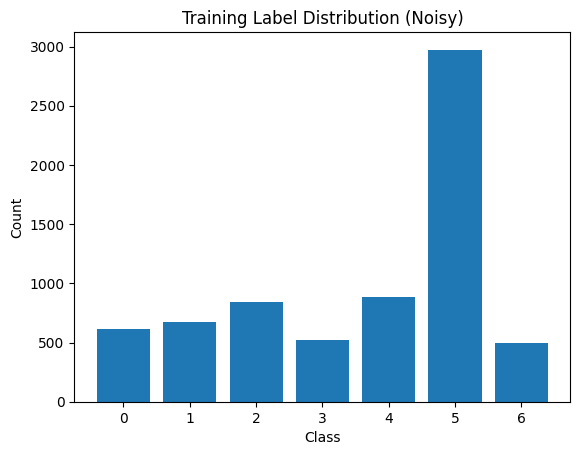

Class weights: {np.int64(0): np.float64(1.625), np.int64(1): np.float64(1.4940298507462686), np.int64(2): np.float64(1.1846153846153846), np.int64(3): np.float64(1.925), np.int64(4): np.float64(1.1323529411764706), np.int64(5): np.float64(0.3366969391187353), np.int64(6): np.float64(2.006012024048096)}
Epoch 1/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.1755 - loss: 2.0052 - val_accuracy: 0.1466 - val_loss: 1.8102 - learning_rate: 5.0000e-04
Epoch 2/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.2463 - loss: 1.9296 - val_accuracy: 0.4267 - val_loss: 1.8154 - learning_rate: 5.0000e-04
Epoch 3/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.2401 - loss: 1.9362 - val_accuracy: 0.6610 - val_loss: 1.6608 - learning_rate: 5.0000e-04
Epoch 4/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.2675 - loss: 1.9145 - val_accuracy: 0.6730 - val_loss: 1.5200 - learning_rate: 5.0000e-04
Epoch 5/60
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - acc

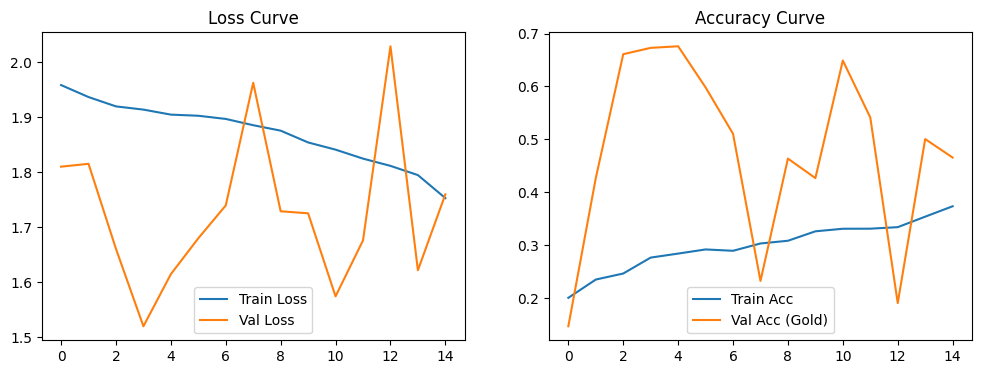

FINAL Validation Accuracy (Gold): 0.6760
Final model saved as final_model.keras


In [ ]:

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


data = np.load("candidate_dataset.npz")

x_train = data["x_train"]
y_train = np.asarray(data["y_train"]).reshape(-1).astype(int)

x_val = data["x_val"]
y_val = np.asarray(data["y_val"]).reshape(-1).astype(int)

num_classes = 7


def to_grayscale(X):
    if X.ndim == 4 and X.shape[-1] == 3:
        return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X])
    return X

def preprocess_images(X):
    out = []
    for img in X:
        img = img.astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        img = clahe.apply(img)
        img = img / 255.0
        out.append(img)
    return np.array(out)


x_train = preprocess_images(to_grayscale(x_train))[..., np.newaxis]
x_val   = preprocess_images(to_grayscale(x_val))[..., np.newaxis]

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes)


unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title("Training Label Distribution (Noisy)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights_array))
print("Class weights:", class_weights)


model = models.Sequential([
    layers.Input(shape=(28,28,1)),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)


callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5
    ),
    ModelCheckpoint(
        "best_model.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]


history = model.fit(
    x_train, y_train_oh,
    validation_data=(x_val, y_val_oh),
    epochs=60,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc (Gold)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


val_loss, val_acc = model.evaluate(x_val, y_val_oh, verbose=0)
print(f"FINAL Validation Accuracy (Gold): {val_acc:.4f}")

model.save("final_model.keras")
print("Final model saved as final_model.keras")


def evaluate_hidden_test(npz_path, model_path="final_model.keras"):
    model = tf.keras.models.load_model(model_path)
    data = np.load(npz_path)

    X = data["x"]
    y = np.asarray(data["y"]).reshape(-1).astype(int)
    y = tf.keras.utils.to_categorical(y, num_classes)

    X = preprocess_images(to_grayscale(X))[..., np.newaxis]

    loss, acc = model.evaluate(X, y, verbose=0)
    print(f"Hidden Test Accuracy: {acc:.4f}")
    return acc


In [ ]:
import tensorflow as tf

num_classes = 7
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)


In [ ]:
best_model  = tf.keras.models.load_model("best_model.keras")
final_model = tf.keras.models.load_model("final_model.keras")

print("Both models loaded successfully")

best_loss, best_acc = best_model.evaluate(
    x_val, y_val_oh,
    batch_size=64,
    verbose=1
)

print(f"\nBEST MODEL → Validation Accuracy: {best_acc:.4f}")
final_loss, final_acc = final_model.evaluate(
    x_val, y_val_oh,
    batch_size=64,
    verbose=1
)

print(f"\nFINAL MODEL → Validation Accuracy: {final_acc:.4f}")


Both models loaded successfully ✅
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7014 - loss: 1.5962

BEST MODEL → Validation Accuracy: 0.6760
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7014 - loss: 1.5962

FINAL MODEL → Validation Accuracy: 0.6760
